# Requirement 3 - Sentiment Analysis

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, HashingVectorizer, TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
np.random.seed(54)
tf.random.set_seed(54)

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,Content,Label,Id
0,Whoever made this movie must have done it as a...,0,0
1,I love this movie because I grew up around har...,1,1
2,"I had some expectation for the movie, since it...",0,2
3,"During the early 1980's, Kurt Thomas was somet...",0,3
4,Poor Will would be rolling over in his grave i...,0,4


In [7]:
df.info()
len_start = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
Content    25000 non-null object
Label      25000 non-null int64
Id         25000 non-null int64
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [8]:
# Remove articles with duplicate content

df.drop_duplicates(subset='Content', keep='last', inplace=True)

In [9]:
df.info()
len_end = len(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24904 entries, 0 to 24999
Data columns (total 3 columns):
Content    24904 non-null object
Label      24904 non-null int64
Id         24904 non-null int64
dtypes: int64(2), object(1)
memory usage: 778.2+ KB


In [10]:
# Display number of duplicates in the dataset

print('{} duplicate articles were removed from the dataset'
      .format(len_start - len_end))

96 duplicate articles were removed from the dataset


In [11]:
# Relative frequency of labels

rel_freq = df.groupby('Label').Content.count() / len(df)
print(rel_freq)

Label
0    0.499197
1    0.500803
Name: Content, dtype: float64


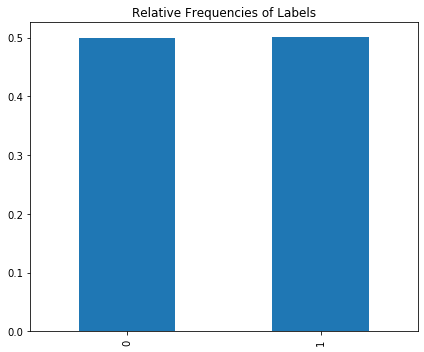

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))
rel_freq.plot.bar(ax=ax)
ax.set_title('Relative Frequencies of Labels')
ax.set_xlabel('')
fig.tight_layout()
plt.savefig('label_freq.png')
plt.show()

In [13]:
def get_metrics(y_true, y_pred, metrics):
    metrics[0] += accuracy_score(y_true, y_pred)
    metrics[1] += precision_score(y_true, y_pred, average='macro')
    metrics[2] += recall_score(y_true, y_pred, average='macro')
    metrics[3] += f1_score(y_true, y_pred, average='macro')
    return metrics

In [14]:
def evaluate_classifier(clf, kfold, X, y, vectorizer, svd_enable=False):
    metrics = np.zeros(4)
    if svd_enable:
        svd = TruncatedSVD(n_components=300)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        X_train_gen = [x for x in X_train]
        vectorizer.fit(X_train_gen)
        X_train_vec = vectorizer.transform(X_train_gen)
        if svd_enable:
            svd.fit(X_train_vec, y_train)
            X_train_vec = svd.transform(X_train_vec)
        clf.fit(X_train_vec, y_train)
        X_cv_gen = [x for x in X_cv]
        X_cv_vec = vectorizer.transform(X_cv_gen)
        if svd_enable:
            X_cv_vec = svd.transform(X_cv_vec)
        y_pred = clf.predict(X_cv_vec)
        metrics = get_metrics(y_cv, y_pred, metrics)
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))

## Classic machine learning method

In [15]:
# 5-Fold cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# TF-IDF vectorizer and stop words

stop_words = ENGLISH_STOP_WORDS
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                        max_df=0.45, ngram_range=(1, 2))

# SVM

svm = LinearSVC()

In [16]:
X = df['Content'].to_dense().values
y = df['Label'].to_dense().values

In [17]:
# SVM - BoW

evaluate_classifier(svm, kf, X, y, tfidf)

Evaluation of classifier finished in 69.67 s 
Average accuracy: 89.78 % 
Average precision: 89.81 % 
Average recall: 89.78 % 
Average f-measure: 89.78 % 



## Deep neural network method

In [18]:
def evaluate_neural_net(kfold, X, y, vectorizer):
    i = 1
    metrics = np.zeros(4)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        vectorizer.fit(X_train)
        X_train_vec = vectorizer.transform(X_train)
        input_shape = X_train_vec.shape[1:]
        model, early_stopping, model_checkpoint = build_model(input_shape, i)
        history = model.fit(X_train_vec, y_train,
                            batch_size=256, epochs=80, 
                            callbacks=[early_stopping, 
                                       model_checkpoint],
                            verbose=0, validation_split=0.10)
        final_model = keras.models.load_model('imdb_sentiment_{}.h5'.format(i))
        X_cv_vec = vectorizer.transform(X_cv)
        prediction = final_model.predict(X_cv_vec)
        y_pred = (prediction > 0.5)
        y_pred = y_pred * 1
        metrics = get_metrics(y_cv, y_pred, metrics)
        i += 1
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))
    
    return history

In [19]:
def build_model(input_shape, i):
    
    keras.backend.clear_session()
    model = keras.Sequential([
        keras.layers.Dropout(0.25, input_shape=input_shape),
        keras.layers.Dense(96, activation='relu'),
        keras.layers.Dropout(0.9),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.85),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    early_stopping = keras.callbacks.EarlyStopping(patience=3)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
                       'imdb_sentiment_{}.h5'.format(i), save_best_only=True)
    optimizer = keras.optimizers.Adam(lr=0.005, amsgrad=True)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model, early_stopping, model_checkpoint

In [20]:
X = df['Content'].values
y = df['Label'].values

In [21]:
# 5-Fold cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=56)

# TF-IDF vectorizer and stop words

stop_words = ENGLISH_STOP_WORDS
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                        max_df=0.45, ngram_range=(1, 2))

In [22]:
# Evaluate the neural network

history = evaluate_neural_net(kf, X, y, tfidf)

Evaluation of classifier finished in 2858.52 s 
Average accuracy: 90.31 % 
Average precision: 90.35 % 
Average recall: 90.31 % 
Average f-measure: 90.31 % 



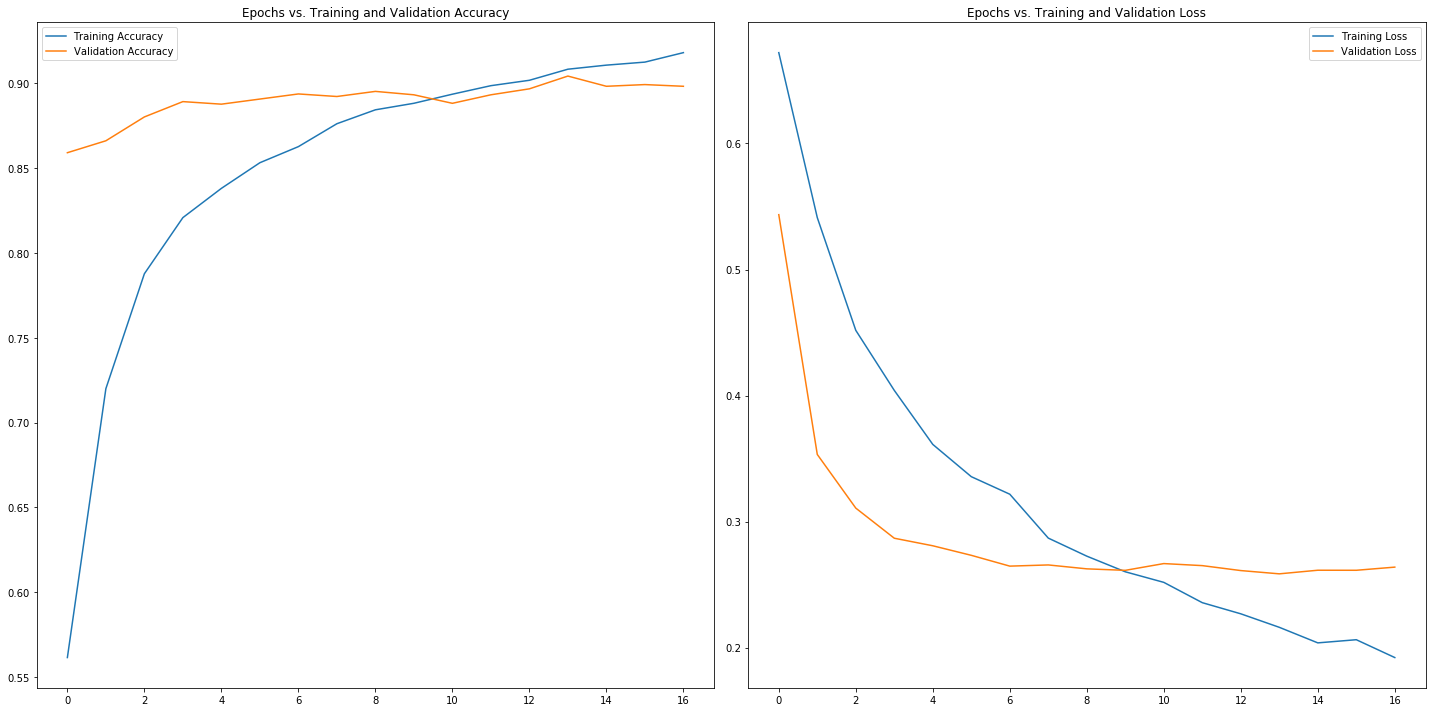

In [23]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.tight_layout()
plt.savefig('accuracy_loss.png')
plt.show()

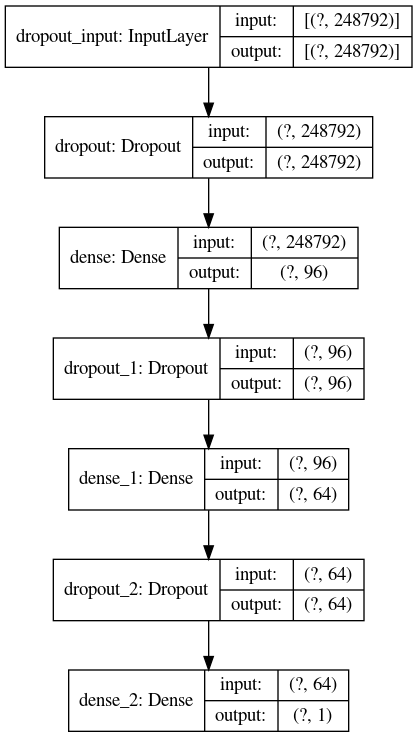

In [24]:
# Visualize the architecture of the model

i = 1

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

X_train_vec = tfidf.fit_transform(X_train_cv)
    
model, early_stopping, model_checkpoint = build_model(X_train_vec.shape[1:], 1)
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                       show_layer_names=True, rankdir='TB')

## Proposed method

In [25]:
X = df['Content'].to_dense().values
y = df['Label'].to_dense().values

In [26]:
# Split the dataset into train-cv set and test set

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.20, 
                                                          shuffle=True, random_state=42)

In [27]:
# Classifiers

svm = LinearSVC(C=0.90, tol=1e-05, max_iter=1500)
ridge = RidgeClassifier(alpha=1.10, tol=1e-5)
pas_agr = PassiveAggressiveClassifier(C=0.80, early_stopping=True, tol=1e-5,
                                      loss='squared_hinge', n_jobs=-1)
sgd = SGDClassifier(early_stopping=True, tol=1e-5, max_iter=1500,
                    loss='modified_huber', penalty='elasticnet',
                    l1_ratio=0.05, n_jobs=-1)

In [28]:
# TF-IDF vectorizer

tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                        max_df=0.45, ngram_range=(1, 2))

In [29]:
# Linear SVM classifier

evaluate_classifier(svm, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 72.49 s 
Average accuracy: 89.52 % 
Average precision: 89.54 % 
Average recall: 89.51 % 
Average f-measure: 89.52 % 



In [30]:
# Ridge classifier

evaluate_classifier(ridge, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 79.84 s 
Average accuracy: 89.48 % 
Average precision: 89.51 % 
Average recall: 89.47 % 
Average f-measure: 89.47 % 



In [31]:
# Passive Aggressive classifier

evaluate_classifier(pas_agr, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 77.26 s 
Average accuracy: 89.04 % 
Average precision: 89.05 % 
Average recall: 89.03 % 
Average f-measure: 89.03 % 



In [32]:
# Stochastic Gradient Descent classifier

evaluate_classifier(sgd, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 65.61 s 
Average accuracy: 89.06 % 
Average precision: 89.10 % 
Average recall: 89.05 % 
Average f-measure: 89.05 % 



In [33]:
# Voting ensemble of 3 classifiers

boost = VotingClassifier(estimators=[
                        ('svc', svm), ('ridge', ridge), ('pas_agr', pas_agr)],
                        voting='hard', n_jobs=-1)

In [34]:
# Voting classifier (Cross Validation)

evaluate_classifier(boost, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 86.85 s 
Average accuracy: 89.46 % 
Average precision: 89.49 % 
Average recall: 89.46 % 
Average f-measure: 89.46 % 



In [35]:
# Evaluate ensemble on test set

metrics = np.zeros(4)
X_train_gen = [x for x in X_train_cv]
tfidf.fit(X_train_cv)
X_train_vec = tfidf.transform(X_train_gen)
boost.fit(X_train_vec, y_train_cv)
X_test_gen = [x for x in X_test]
X_test_vec = tfidf.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Evaluation of ensemble classifier on test set \n'
      'Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Evaluation of ensemble classifier on test set 
Average accuracy: 89.96 % 
Average precision: 89.97 % 
Average recall: 89.97 % 
Average f-measure: 89.96 % 



## Deliverable for competition

In [36]:
df_test = pd.read_csv('test_without_labels.csv')

In [37]:
X_final = df_test['Content'].values

In [38]:
# Predict unlabeled dataset

X_train_gen = [x for x in X]
tfidf.fit(X_train_gen)
X_train_vec = tfidf.transform(X_train_gen)
boost.fit(X_train_vec, y)
X_test_gen = [x for x in X_final]
X_test_vec = tfidf.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)

In [39]:
df_results = pd.DataFrame({'Id':df_test['Id'], 'Predicted':y_pred})

In [40]:
df_results.to_csv('sentiment_predictions.csv', index=False, header=True)